All findings will be implemented in `data_processing.py`
# Findings so far
- Creating a weekend vs weekday feature helps capture bike rentals changing depending on the time of week
- `Hour` was removed as a result of aggregating to daily obervations
- `Functioning Day` determines whether the bike shop is open or not. If it's not open, no rentals. This is impossible for the model to learn when there are only 12 days so the feature was removed
	- Consequently, the rows where the bike shop were closed were also removed because keeping them would mislead the model in believing that good weather sometimes leads in no rentals
- `Holiday` was removed because there are very few holidays (class imbalance) and a very poor correlation with the target value (-0.11)
- `Dew point temperature` is extremely correlated with `Temperature` (0.96) and provides no unique insight or effect on bike rentals
- `Summer*Temp` helps capture the interaction between Summer and Temperature, e.g. if it's too hot in the summer, no rentals
- `Visibility` was removed as it provided little to no effect on bike rentals and only contributed to noise within the dataset
- `Snowfall` was removed as it provided a similar effect on bike rentals as rainfall. Removing it contributed in lowering overfitting and RMSE (reduced noise)\
- Using a quantile transformer for the target value helped get rid of heteroskedasticity

In [35]:
import sys
sys.dont_write_bytecode = True

# uncomment load_ext line when you initially use the file, after you can comment to get rid of the warning that'll show up
%load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = '../data/bike.csv'
df = pd.read_csv(path, encoding_errors='ignore', parse_dates=['Date'], dayfirst=True)
pd.set_option('display.max_columns', None) # lets you scroll if your monitor isn't wide enough
display(df)

from sklearn.linear_model import HuberRegressor

# pulled from modeling file
reg = HuberRegressor()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2018-06-19,3556,18,24.1,57,2.9,1301,15.0,0.56,0.0,0.0,Summer,No Holiday,Yes
1,2018-06-21,3418,18,27.8,43,3.0,1933,14.0,1.35,0.0,0.0,Summer,No Holiday,Yes
2,2018-06-12,3404,18,24.9,53,3.6,2000,14.6,1.28,0.0,0.0,Summer,No Holiday,Yes
3,2018-06-20,3384,18,27.0,55,3.1,1246,17.1,1.26,0.0,0.0,Summer,No Holiday,Yes
4,2018-06-04,3380,18,24.4,48,1.9,1998,12.6,0.56,0.0,0.0,Summer,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-09,0,19,11.9,71,2.7,589,6.7,0.00,0.0,0.0,Autumn,No Holiday,No
8756,2018-11-09,0,20,11.9,72,2.5,526,7.0,0.00,0.0,0.0,Autumn,No Holiday,No
8757,2018-11-09,0,21,11.4,74,1.9,498,6.9,0.00,0.0,0.0,Autumn,No Holiday,No
8758,2018-11-09,0,22,11.2,75,1.7,478,6.9,0.00,0.0,0.0,Autumn,No Holiday,No


I'd like to have Rainfall and Snowfall in the same units.
<br>After converting that feature, I'll have to rename it so might as well rename some others for consistent formatting

In [36]:
df['Snowfall (cm)'] = df['Snowfall (cm)'] * 10
df.rename(columns={
    'Wind speed (m/s)' : 'Wind Speed(m/s)',
    'Solar Radiation (MJ/m2)' : 'Solar Radiation(MJ/m2)',
    'Snowfall (cm)' : 'Snowfall(mm)',
    'Visibility (10m)' : 'Visibility(10m)'}, inplace=True)

We should One-hot encode our seasons and convert our binary categorical features to boolean
<br>Then we can convert them all to integers

In [37]:
df = pd.get_dummies(df, columns=['Seasons'], drop_first=False, prefix='', prefix_sep='')
df['Functioning Day'] = df['Functioning Day'].apply(lambda x: x == 'Yes')
df['Holiday'] = df['Holiday'].apply(lambda x: x == 'Holiday')
df = df.astype({col: int for col in df.select_dtypes('bool').columns})
display(df)

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind Speed(m/s),Visibility(10m),Dew point temperature(C),Solar Radiation(MJ/m2),Rainfall(mm),Snowfall(mm),Holiday,Functioning Day,Autumn,Spring,Summer,Winter
0,2018-06-19,3556,18,24.1,57,2.9,1301,15.0,0.56,0.0,0.0,0,1,0,0,1,0
1,2018-06-21,3418,18,27.8,43,3.0,1933,14.0,1.35,0.0,0.0,0,1,0,0,1,0
2,2018-06-12,3404,18,24.9,53,3.6,2000,14.6,1.28,0.0,0.0,0,1,0,0,1,0
3,2018-06-20,3384,18,27.0,55,3.1,1246,17.1,1.26,0.0,0.0,0,1,0,0,1,0
4,2018-06-04,3380,18,24.4,48,1.9,1998,12.6,0.56,0.0,0.0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-09,0,19,11.9,71,2.7,589,6.7,0.00,0.0,0.0,0,0,1,0,0,0
8756,2018-11-09,0,20,11.9,72,2.5,526,7.0,0.00,0.0,0.0,0,0,1,0,0,0
8757,2018-11-09,0,21,11.4,74,1.9,498,6.9,0.00,0.0,0.0,0,0,1,0,0,0
8758,2018-11-09,0,22,11.2,75,1.7,478,6.9,0.00,0.0,0.0,0,0,1,0,0,0


It would be a good idea to also implement a Weekend vs Weekday feature as peoeple might be more or less inclined to bike depending on the time of week

In [38]:
df['Weekend'] = df['Date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
display(df)

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind Speed(m/s),Visibility(10m),Dew point temperature(C),Solar Radiation(MJ/m2),Rainfall(mm),Snowfall(mm),Holiday,Functioning Day,Autumn,Spring,Summer,Winter,Weekend
0,2018-06-19,3556,18,24.1,57,2.9,1301,15.0,0.56,0.0,0.0,0,1,0,0,1,0,0
1,2018-06-21,3418,18,27.8,43,3.0,1933,14.0,1.35,0.0,0.0,0,1,0,0,1,0,0
2,2018-06-12,3404,18,24.9,53,3.6,2000,14.6,1.28,0.0,0.0,0,1,0,0,1,0,0
3,2018-06-20,3384,18,27.0,55,3.1,1246,17.1,1.26,0.0,0.0,0,1,0,0,1,0,0
4,2018-06-04,3380,18,24.4,48,1.9,1998,12.6,0.56,0.0,0.0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-09,0,19,11.9,71,2.7,589,6.7,0.00,0.0,0.0,0,0,1,0,0,0,0
8756,2018-11-09,0,20,11.9,72,2.5,526,7.0,0.00,0.0,0.0,0,0,1,0,0,0,0
8757,2018-11-09,0,21,11.4,74,1.9,498,6.9,0.00,0.0,0.0,0,0,1,0,0,0,0
8758,2018-11-09,0,22,11.2,75,1.7,478,6.9,0.00,0.0,0.0,0,0,1,0,0,0,0


We need daily data not hourly, so we must aggregate our observations

In [39]:
agg_dict = {
		'Rented Bike Count' : 'sum',
		'Temperature(C)' : 'mean',
		'Dew point temperature(C)' : 'mean',
		'Humidity(%)' : 'mean',
		'Wind Speed(m/s)' : 'mean',
		'Visibility(10m)' : 'mean',
		'Solar Radiation(MJ/m2)' : 'max',
		'Rainfall(mm)' : 'sum', # taking the sum of rain makes the data more meaningful because we have a lot of hours without it, making it too imbalanced if we avg, this might help
		'Snowfall(mm)' : 'sum',
		'Spring' : 'first', # our categorical variables dont change throughout the day so we can take the value at the first hour to represent the entire day
		'Summer' : 'first',
        'Autumn' : 'first',
		'Winter' : 'first',
		'Holiday' : 'first',
		'Functioning Day' : 'first',
		'Weekend' : 'first'
}
df = df.groupby('Date').agg(agg_dict) # turning hourly data into daily data
display(df)

,Rented Bike Count,Temperature(C),Dew point temperature(C),Humidity(%),Wind Speed(m/s),Visibility(10m),Solar Radiation(MJ/m2),Rainfall(mm),Snowfall(mm),Spring,Summer,Autumn,Winter,Holiday,Functioning Day,Weekend
Date,,,,,,,,,,,,,,,,
2017-12-01,9539,-2.454167,-13.545833,45.875000,1.537500,1870.750000,1.16,0.0,0.0,0,0,0,1,0,1,0
2017-12-02,8523,1.325000,-5.716667,61.958333,1.712500,1471.083333,1.12,0.0,0.0,0,0,0,1,0,1,1
2017-12-03,7222,4.875000,1.883333,81.541667,1.612500,455.750000,0.69,4.0,0.0,0,0,0,1,0,1,1
2017-12-04,8729,-0.304167,-9.925000,52.500000,3.450000,1362.833333,1.17,0.1,0.0,0,0,0,1,0,1,0
2017-12-05,8307,-4.458333,-17.425000,36.416667,1.108333,1959.458333,0.64,0.0,0.0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26,17162,6.320833,0.845833,70.500000,1.029167,475.000000,1.74,0.0,29.0,0,0,1,0,0,1,0
2018-11-27,16282,7.066667,1.000000,68.000000,1.350000,405.291667,0.87,0.0,0.0,0,0,1,0,0,1,0
2018-11-28,16524,5.304167,-13.350000,25.791667,1.695833,1429.083333,1.86,0.0,0.0,0,0,1,0,0,1,0


That should be enough cleaning, now we can explore

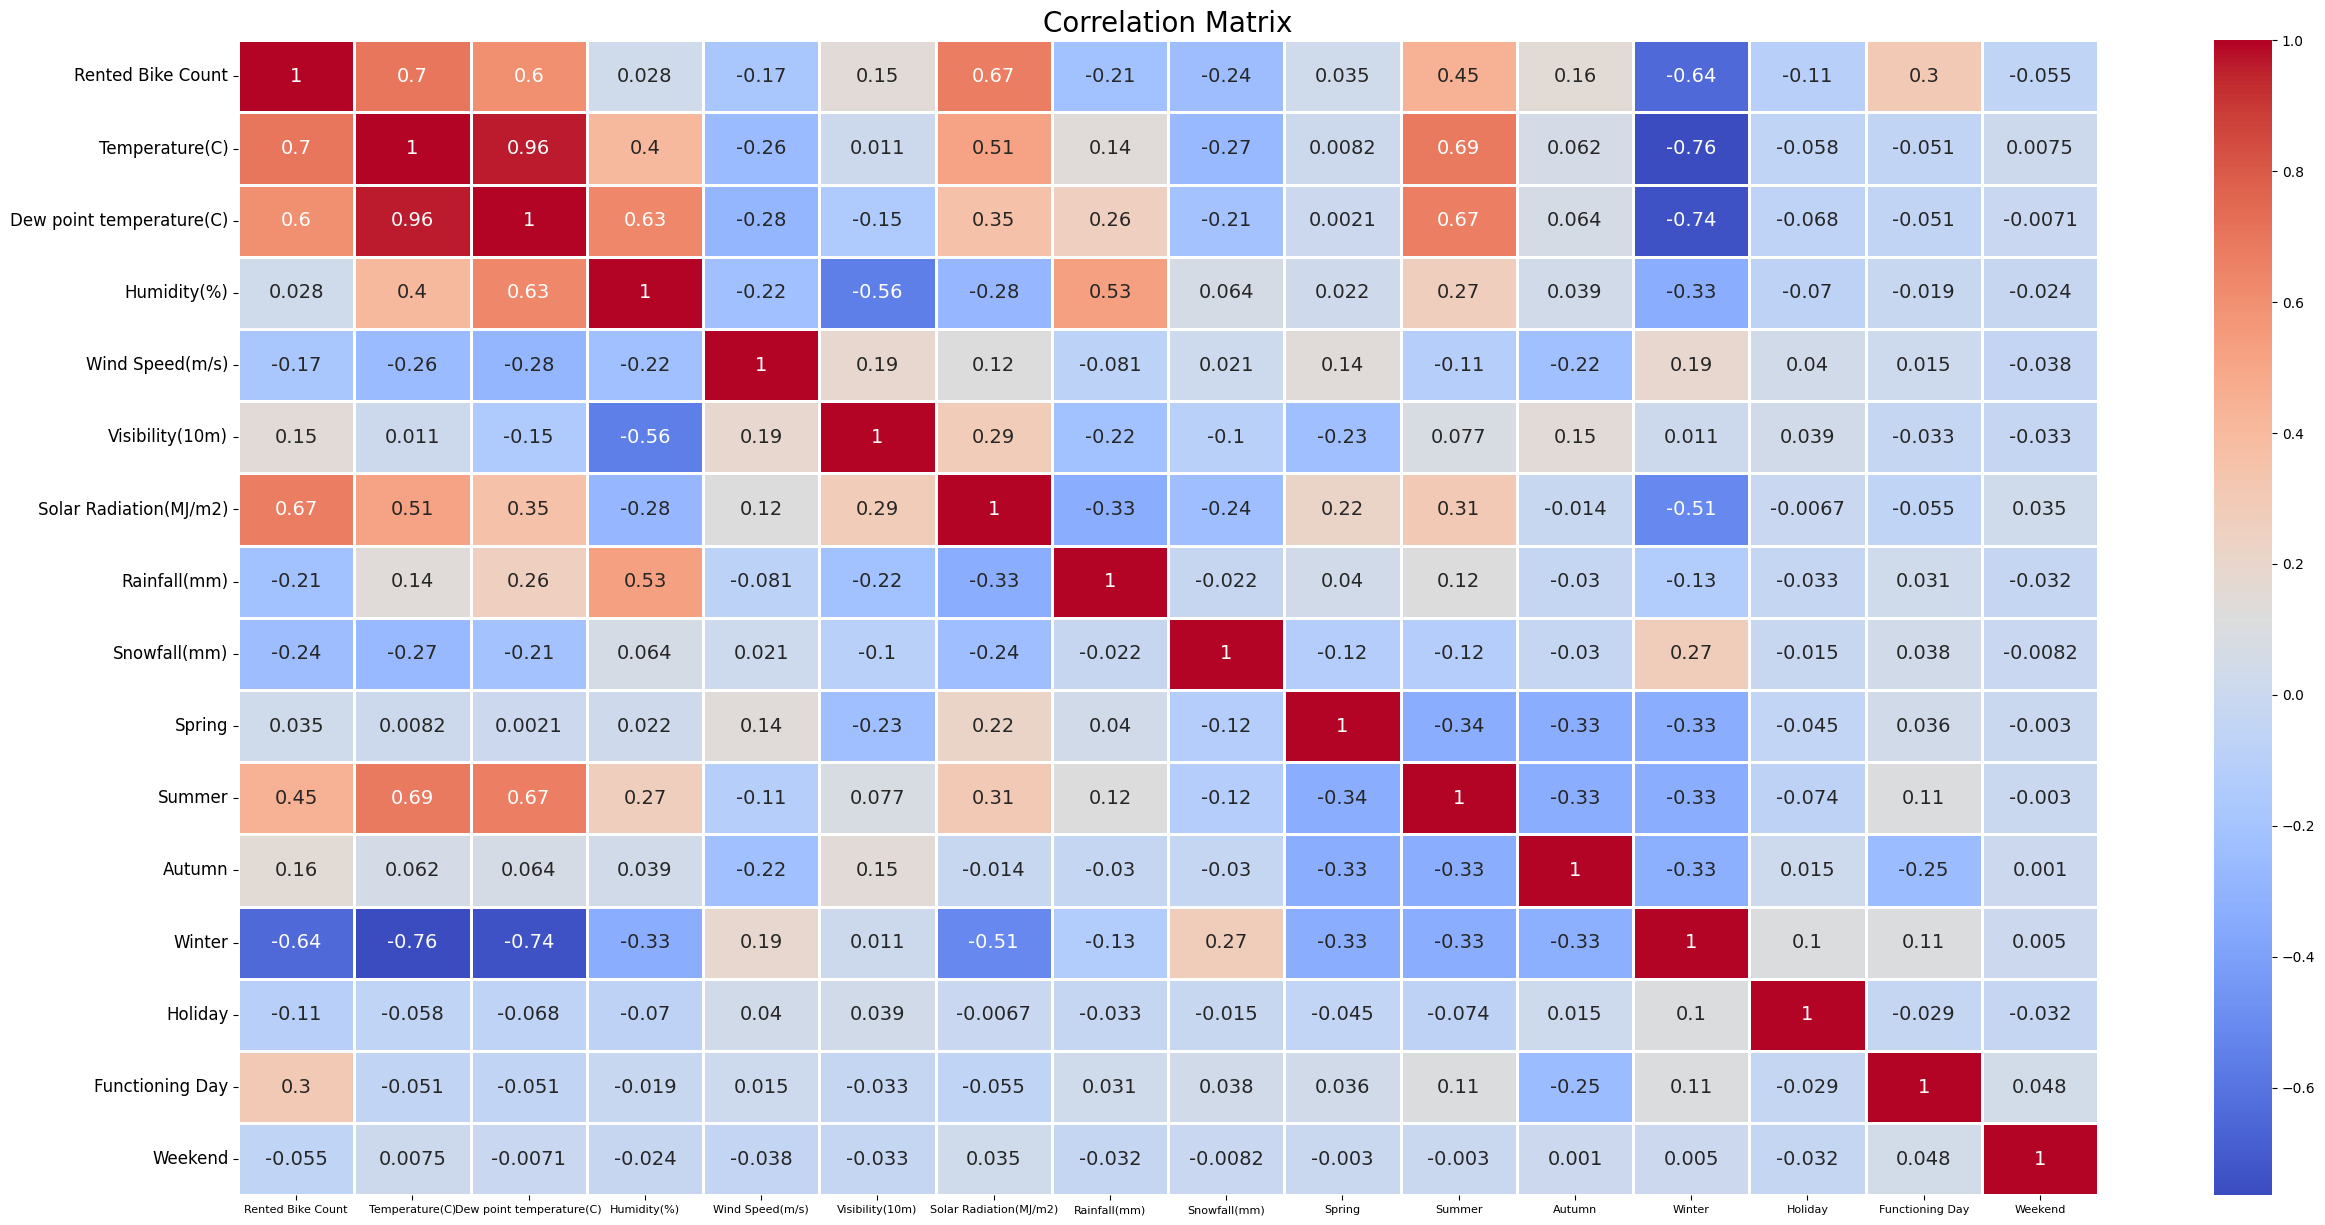

,Rented Bike Count,Temperature(C),Dew point temperature(C),Humidity(%),Wind Speed(m/s),Visibility(10m),Solar Radiation(MJ/m2),Rainfall(mm),Snowfall(mm),Spring,Summer,Autumn,Winter,Holiday,Functioning Day,Weekend
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,16910.449315,12.882922,4.073813,58.226256,1.724909,1436.825799,2.078274,3.568493,18.016438,0.252055,0.252055,0.249315,0.246575,0.049315,0.967123,0.284932
std,10258.639202,11.555997,12.808952,14.673269,0.601884,491.249597,0.900842,11.846930,86.644561,0.434789,0.434789,0.433210,0.431609,0.216822,0.178559,0.452001
min,0.000000,-14.737500,-27.750000,22.250000,0.662500,214.291667,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6500.000000,3.812500,-4.862500,47.916667,1.295833,1087.541667,1.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,17730.000000,13.837500,5.008333,57.208333,1.641667,1557.750000,2.230000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,26075.000000,22.425000,14.570833,67.541667,1.954167,1877.250000,2.870000,0.500000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,36149.000000,33.741667,25.037500,95.875000,4.000000,2000.000000,3.520000,95.500000,787.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
corr_matrix = df.corr()
plt.figure(figsize=(30, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 14}, linewidths=2)
plt.title("Correlation Matrix", fontsize=20)
plt.yticks(fontsize=12, rotation=0)
plt.xticks(fontsize=8, rotation=0)
plt.show()
df.describe()

A couple things stick out from the data's statistics
- `Functioning Day` means the bike shop is closed so there shouldn't be any rentals, but the mean shows that our values are very skewed left. Too little non-functioning days to enforce that real-world rule
- `Holiday` suffers from a similar problem with very right skewed data, meaning many days aren't holidays
<p>Going forward, it'll be easier to drop these features to avoid a headache. By dropping those features, I'll have to drop the days where it wasn't a functioning day since they have no bike count. We dont want the model learning that good weather sometimes leads to no rentals

In [14]:
df.drop(df[df['Functioning Day'] == 0].index, inplace=True)
df.drop(['Holiday', 'Functioning Day'], axis = 1, inplace=True)
display(df)

,Rented Bike Count,Temperature(C),Dew point temperature(C),Humidity(%),Wind Speed(m/s),Visibility(10m),Solar Radiation(MJ/m2),Rainfall(mm),Snowfall(mm),Spring,Summer,Autumn,Winter,Weekend
Date,,,,,,,,,,,,,,
2017-12-01,9539,-2.454167,-13.545833,45.875000,1.537500,1870.750000,1.16,0.0,0.0,0,0,0,1,0
2017-12-02,8523,1.325000,-5.716667,61.958333,1.712500,1471.083333,1.12,0.0,0.0,0,0,0,1,1
2017-12-03,7222,4.875000,1.883333,81.541667,1.612500,455.750000,0.69,4.0,0.0,0,0,0,1,1
2017-12-04,8729,-0.304167,-9.925000,52.500000,3.450000,1362.833333,1.17,0.1,0.0,0,0,0,1,0
2017-12-05,8307,-4.458333,-17.425000,36.416667,1.108333,1959.458333,0.64,0.0,0.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26,17162,6.320833,0.845833,70.500000,1.029167,475.000000,1.74,0.0,29.0,0,0,1,0,0
2018-11-27,16282,7.066667,1.000000,68.000000,1.350000,405.291667,0.87,0.0,0.0,0,0,1,0,0
2018-11-28,16524,5.304167,-13.350000,25.791667,1.695833,1429.083333,1.86,0.0,0.0,0,0,1,0,0


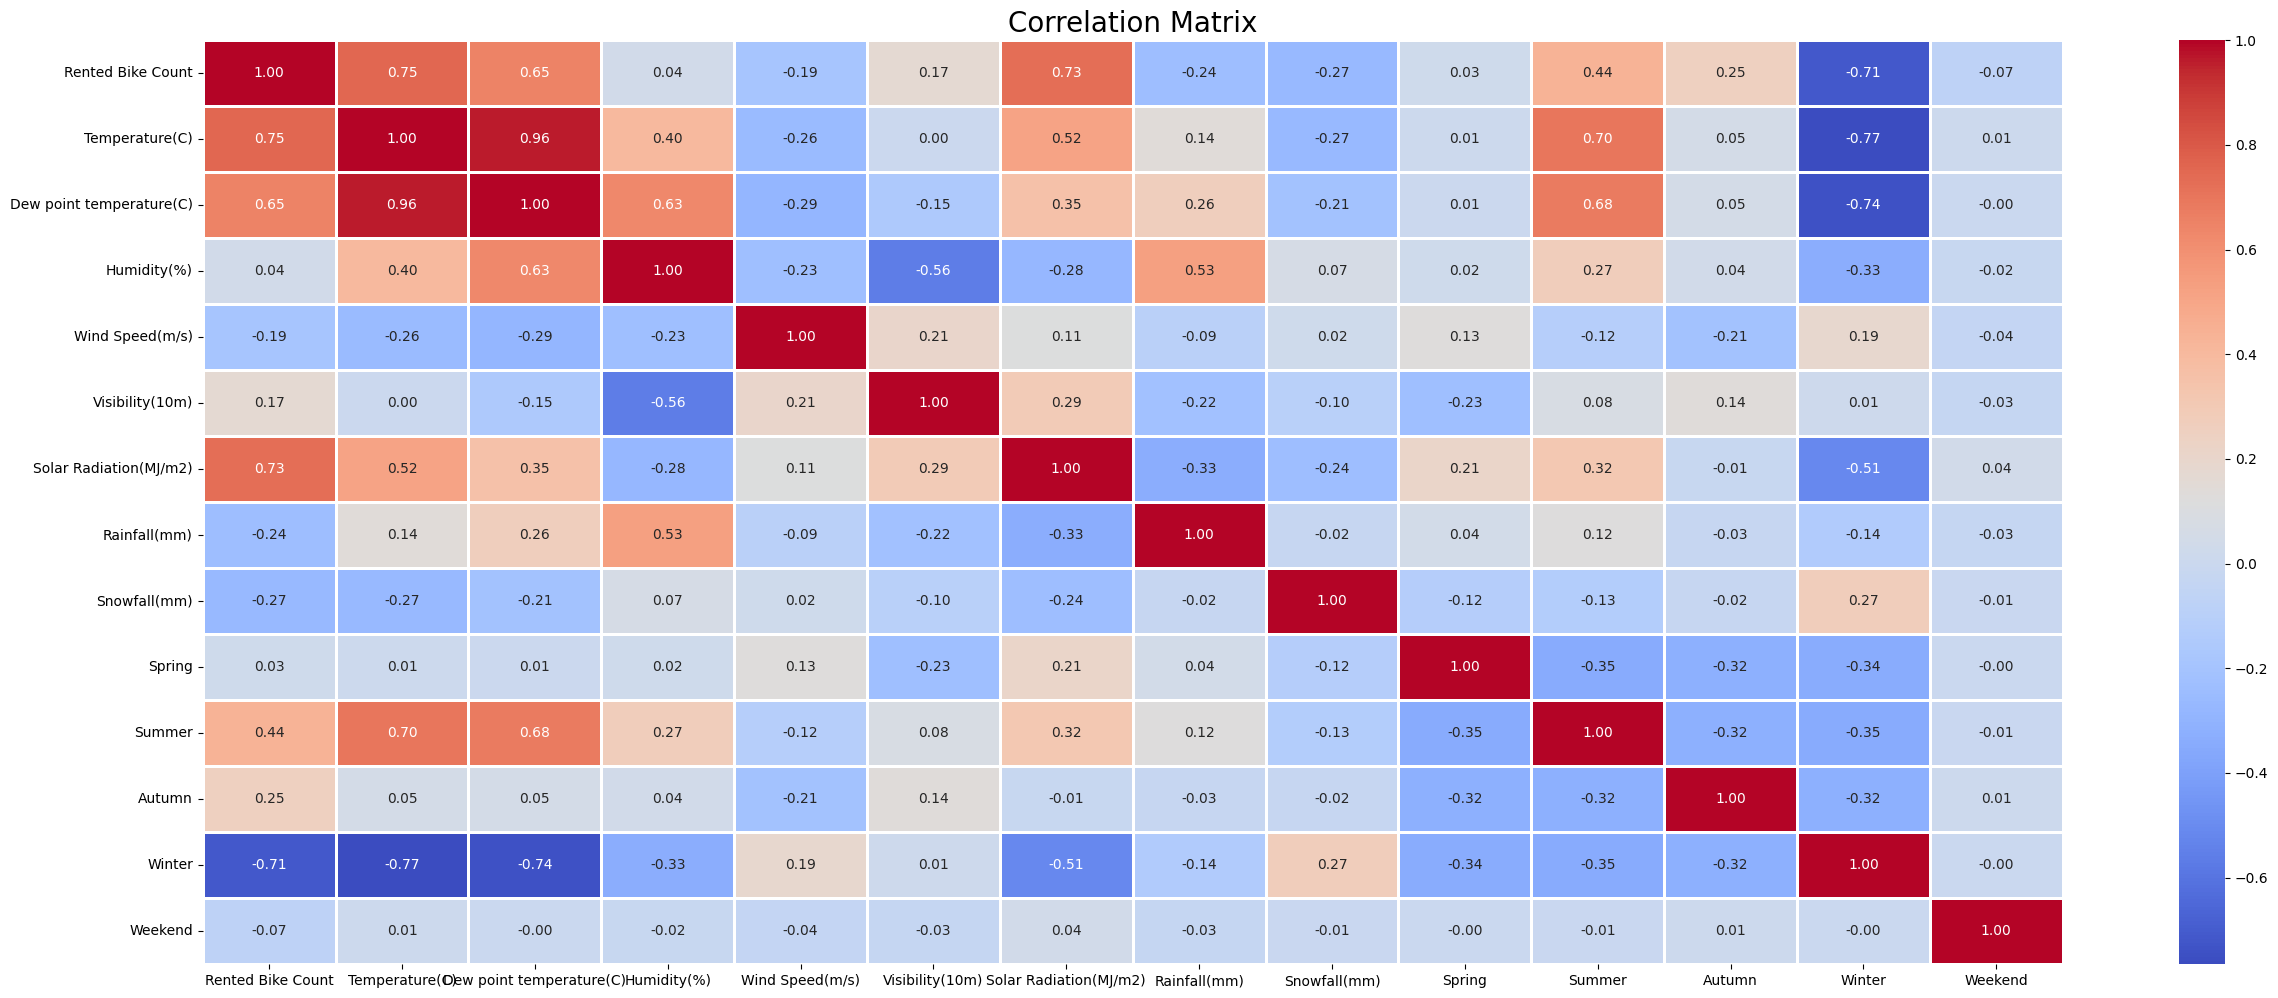

In [15]:
corr_matrix = df.corr()
plt.figure(figsize=(30, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=2)
plt.title("Correlation Matrix", fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

`Dew Point Temperature` and `Temperature` are highly correlated so one has to go. `Temperature` makes more sense to keep so we'll drop the other

In [16]:
df.drop('Dew point temperature(C)', axis=1, inplace=True)
display(df)

,Rented Bike Count,Temperature(C),Humidity(%),Wind Speed(m/s),Visibility(10m),Solar Radiation(MJ/m2),Rainfall(mm),Snowfall(mm),Spring,Summer,Autumn,Winter,Weekend
Date,,,,,,,,,,,,,
2017-12-01,9539,-2.454167,45.875000,1.537500,1870.750000,1.16,0.0,0.0,0,0,0,1,0
2017-12-02,8523,1.325000,61.958333,1.712500,1471.083333,1.12,0.0,0.0,0,0,0,1,1
2017-12-03,7222,4.875000,81.541667,1.612500,455.750000,0.69,4.0,0.0,0,0,0,1,1
2017-12-04,8729,-0.304167,52.500000,3.450000,1362.833333,1.17,0.1,0.0,0,0,0,1,0
2017-12-05,8307,-4.458333,36.416667,1.108333,1959.458333,0.64,0.0,0.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26,17162,6.320833,70.500000,1.029167,475.000000,1.74,0.0,29.0,0,0,1,0,0
2018-11-27,16282,7.066667,68.000000,1.350000,405.291667,0.87,0.0,0.0,0,0,1,0,0
2018-11-28,16524,5.304167,25.791667,1.695833,1429.083333,1.86,0.0,0.0,0,0,1,0,0


I'm also going to assume that Temperature is going to interact with the more extreme seasons (summer, winter)
<br>Like a hot day in winter or cold day in summer. Or on the flip side, it could be either too hot and too cold in either. All of those interactions could affect bike rentals

In [17]:
df["Summer*Temp"] = df['Summer'] * df["Temperature(C)"]
df["Winter*Temp"] = df['Winter'] * df["Temperature(C)"]
display(df)

,Rented Bike Count,Temperature(C),Humidity(%),Wind Speed(m/s),Visibility(10m),Solar Radiation(MJ/m2),Rainfall(mm),Snowfall(mm),Spring,Summer,Autumn,Winter,Weekend,Summer*Temp,Winter*Temp
Date,,,,,,,,,,,,,,,
2017-12-01,9539,-2.454167,45.875000,1.537500,1870.750000,1.16,0.0,0.0,0,0,0,1,0,-0.0,-2.454167
2017-12-02,8523,1.325000,61.958333,1.712500,1471.083333,1.12,0.0,0.0,0,0,0,1,1,0.0,1.325000
2017-12-03,7222,4.875000,81.541667,1.612500,455.750000,0.69,4.0,0.0,0,0,0,1,1,0.0,4.875000
2017-12-04,8729,-0.304167,52.500000,3.450000,1362.833333,1.17,0.1,0.0,0,0,0,1,0,-0.0,-0.304167
2017-12-05,8307,-4.458333,36.416667,1.108333,1959.458333,0.64,0.0,0.0,0,0,0,1,0,-0.0,-4.458333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26,17162,6.320833,70.500000,1.029167,475.000000,1.74,0.0,29.0,0,0,1,0,0,0.0,0.000000
2018-11-27,16282,7.066667,68.000000,1.350000,405.291667,0.87,0.0,0.0,0,0,1,0,0,0.0,0.000000
2018-11-28,16524,5.304167,25.791667,1.695833,1429.083333,1.86,0.0,0.0,0,0,1,0,0,0.0,0.000000


Next I'll look at the coefficients that our model gives us and remove the less important features

In [18]:
from sklearn.model_selection import train_test_split

y = df['Rented Bike Count'].to_numpy() # target value
X = df.drop('Rented Bike Count', axis=1) # taking out the target value

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle=True, random_state=1)

In [19]:
from sklearn.metrics import r2_score, mean_squared_error

def featureImportance(model):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    mse = mean_squared_error(y_test, test_pred)
    rmse = np.sqrt(mse)

    print(f"Test Accuracy: {r2_test * 100:.2f}%")
    print(f"Train Accuracy: {r2_train * 100:.2f}%")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    feature_names = X_train.columns

    coefs = model.coef_

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coefs
    })

    # sort by absolute feature importance
    importance_df['Abs_Importance'] = np.abs(importance_df['Importance'])
    importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)

    print(importance_df[['Feature', 'Importance']])
featureImportance(reg)

Test Accuracy: 67.16%
Train Accuracy: 72.38%
Mean Squared Error: 31514860.99
Root Mean Squared Error: 5613.81
                   Feature  Importance
0           Temperature(C)  948.761777
5             Rainfall(mm) -369.851802
12             Summer*Temp -350.471647
13             Winter*Temp -273.594811
4   Solar Radiation(MJ/m2)  238.761931
10                  Winter -120.866474
9                   Autumn  111.980752
1              Humidity(%)   29.562310
11                 Weekend  -27.186296
2          Wind Speed(m/s)  -25.264770
7                   Spring   12.754995
8                   Summer   10.591619
3          Visibility(10m)    4.195622
6             Snowfall(mm)    2.008771


c:\Users\oo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


`Visibility` and `Snowfall` have the lowest feature importance here so we can remove those and not lose much variation in our model


In [20]:
df.drop(['Visibility(10m)', 'Snowfall(mm)'], axis=1, inplace=True)
X = df.drop('Rented Bike Count', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle=True, random_state=1)

featureImportance(reg)

Test Accuracy: 84.43%
Train Accuracy: 85.15%
Mean Squared Error: 14947075.85
Root Mean Squared Error: 3866.14
                   Feature    Importance
6                   Summer  10432.566858
8                   Winter  -4835.900276
3   Solar Radiation(MJ/m2)   2892.865138
9                  Weekend  -2786.392441
7                   Autumn   2745.044994
5                   Spring  -1720.598785
2          Wind Speed(m/s)   -958.656466
0           Temperature(C)    556.888153
10             Summer*Temp   -551.867157
11             Winter*Temp   -362.988138
4             Rainfall(mm)   -259.504316
1              Humidity(%)     45.695595


c:\Users\oo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Next, I'll plot our model to diagnose our model visually

Test Accuracy: 84.43%
Train Accuracy: 85.15%
Accuracy Difference: -0.72%
Mean Squared Error: 14947075.85
Root Mean Squared Error: 3866.14


c:\Users\oo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


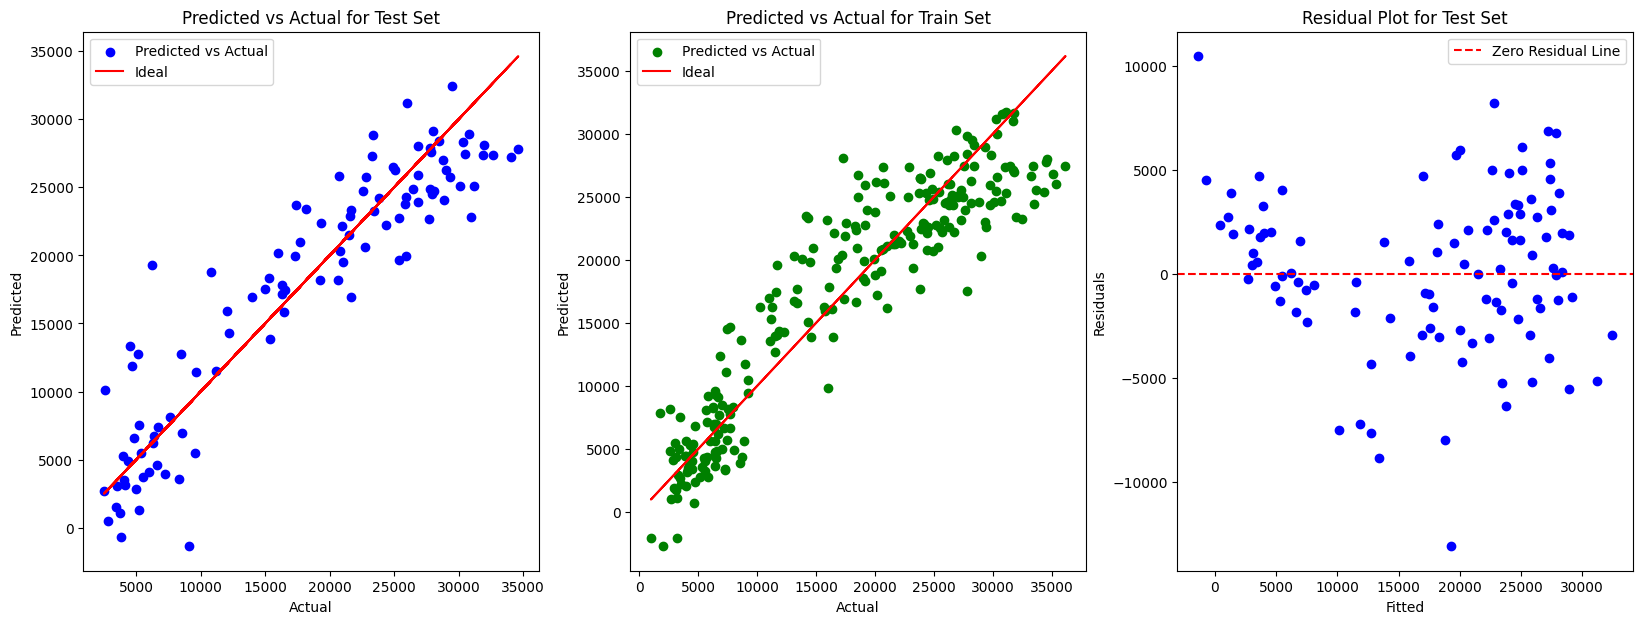

In [21]:
def test_model(model):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    mse = mean_squared_error(y_test, test_pred)
    rmse = np.sqrt(mse)

    print(f"Test Accuracy: {r2_test * 100:.2f}%")
    print(f"Train Accuracy: {r2_train * 100:.2f}%")
    print(f"Accuracy Difference: {(r2_test - r2_train) * 100:.2f}%")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")

    # visualizing
    fig, ax = plt.subplots(1, 3, figsize=(20,7))
    plt.suptitle('')
    ax[0].set_title('Predicted vs Actual for Test Set')
    ax[0].scatter(y_test, test_pred, color='blue', label='Predicted vs Actual')
    ax[0].plot(y_test, y_test, color='red', label='Ideal')
    ax[0].legend()
    ax[0].set_xlabel('Actual')
    ax[0].set_ylabel('Predicted')

    ax[1].set_title('Predicted vs Actual for Train Set')
    ax[1].scatter(y_train, train_pred, color='green', label='Predicted vs Actual')
    ax[1].plot(y_train, y_train, color='red', label='Ideal')
    ax[1].legend()
    ax[1].set_xlabel('Actual')
    ax[1].set_ylabel('Predicted')

    residuals = y_test.reshape(-1,1) - test_pred.reshape(-1,1)
    ax[2].set_title('Residual Plot for Test Set')
    ax[2].scatter(test_pred, residuals, color='blue')
    ax[2].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[2].legend()
    ax[2].set_xlabel("Fitted")
    ax[2].set_ylabel("Residuals")
test_model(reg)

There's a bit of heteroskedasticity so I'll check the distribution of our target

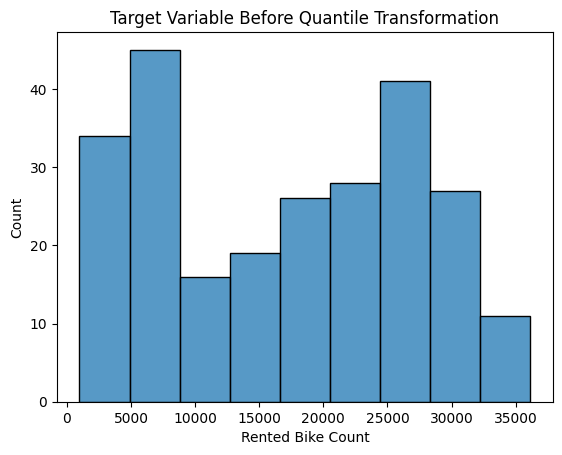

In [22]:
sns.histplot(y_train)
plt.title("Target Variable Before Quantile Transformation")
plt.xlabel('Rented Bike Count')
plt.show()

Our target has a multimodal distribution so it would be best to transform it to achieve a normal distribution.
<br>This will have to be done after splitting to avoid data leakage

c:\Users\oo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (247). n_quantiles is set to n_samples.
  warnings.warn(


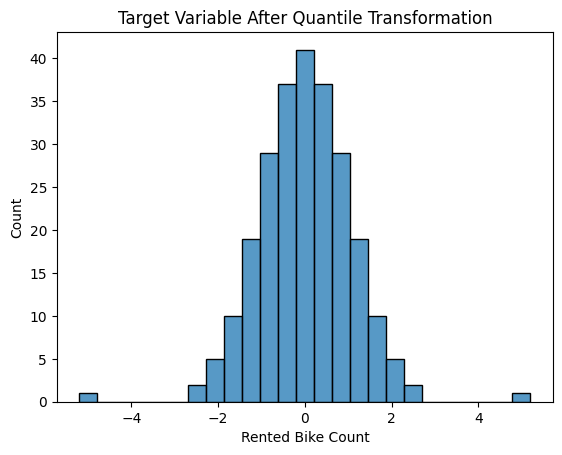

In [23]:
from sklearn.preprocessing import QuantileTransformer

y_transformer = QuantileTransformer(output_distribution='normal', random_state=1)
y_train = y_transformer.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test = y_transformer.transform(y_test.reshape(-1, 1)).ravel()

sns.histplot(y_train)
plt.title("Target Variable After Quantile Transformation")
plt.xlabel('Rented Bike Count')
plt.show()

Now let's test the model again

c:\Users\oo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Test Accuracy: 86.75%
Train Accuracy: 86.75%
Accuracy Difference: 0.00%
Mean Squared Error: 12715908.20
Root Mean Squared Error: 3565.94


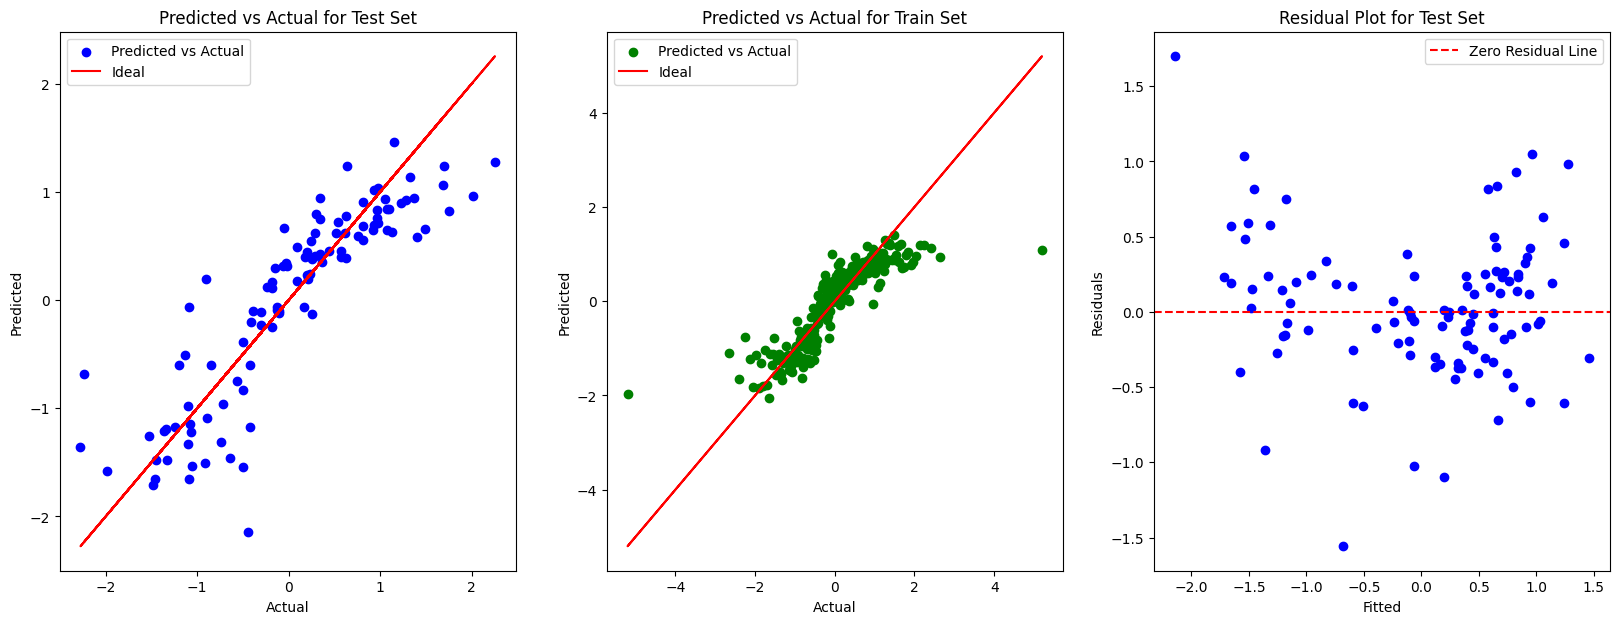

In [127]:
def test_model_2(model):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

	# inversing the transformation when calculating metrics
    train_pred_original = y_transformer.inverse_transform(train_pred.reshape(-1,1))
    test_pred_original = y_transformer.inverse_transform(test_pred.reshape(-1,1))
    y_train_original = y_transformer.inverse_transform(y_train.reshape(-1,1))
    y_test_original = y_transformer.inverse_transform(y_test.reshape(-1,1))
    
    r2_train = r2_score(y_train_original, train_pred_original)
    r2_test = r2_score(y_test_original, test_pred_original)
    mse = mean_squared_error(y_test_original, test_pred_original)
    rmse = np.sqrt(mse)

    print(f"Test Accuracy: {r2_test * 100:.2f}%")
    print(f"Train Accuracy: {r2_train * 100:.2f}%")
    print(f"Accuracy Difference: {(r2_test - r2_train) * 100:.2f}%")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")

    # keeping our visualizations in the transformed space for diagnosing
    fig, ax = plt.subplots(1, 3, figsize=(20,7))
    plt.suptitle('')
    ax[0].set_title('Predicted vs Actual for Test Set')
    ax[0].scatter(y_test, test_pred, color='blue', label='Predicted vs Actual')
    ax[0].plot(y_test, y_test, color='red', label='Ideal')
    ax[0].legend()
    ax[0].set_xlabel('Actual')
    ax[0].set_ylabel('Predicted')

    ax[1].set_title('Predicted vs Actual for Train Set')
    ax[1].scatter(y_train, train_pred, color='green', label='Predicted vs Actual')
    ax[1].plot(y_train, y_train, color='red', label='Ideal')
    ax[1].legend()
    ax[1].set_xlabel('Actual')
    ax[1].set_ylabel('Predicted')

    residuals = y_test.reshape(-1,1) - test_pred.reshape(-1,1)
    ax[2].set_title('Residual Plot for Test Set')
    ax[2].scatter(test_pred, residuals, color='blue')
    ax[2].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[2].legend()
    ax[2].set_xlabel("Fitted")
    ax[2].set_ylabel("Residuals")

    plt.show()
test_model_2(reg)

The metrics are ok but we'll tune in `modeling.ipynb` to get the best hyperparameters

Test Accuracy: 88.51%
Train Accuracy: 88.41%
Accuracy Difference: 0.09%
Mean Squared Error: 11030370.54
Root Mean Squared Error: 3321.20


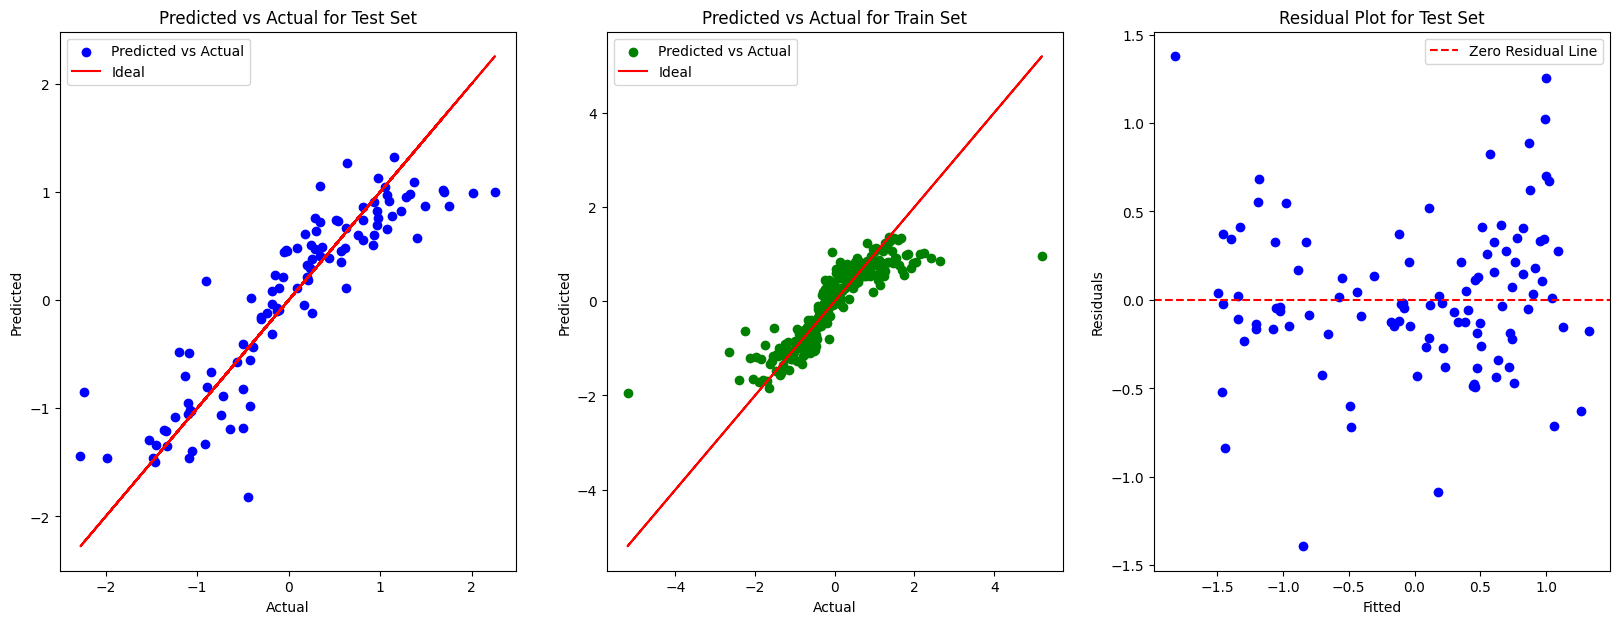

In [128]:
reg = HuberRegressor(epsilon=1.241631, alpha=5.382770, max_iter=1000)
test_model_2(reg)

In [129]:
def featureImportanceTrans(model):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

	# inversing the transformation when calculating metrics
    train_pred_original = y_transformer.inverse_transform(train_pred.reshape(-1,1))
    test_pred_original = y_transformer.inverse_transform(test_pred.reshape(-1,1))
    y_train_original = y_transformer.inverse_transform(y_train.reshape(-1,1))
    y_test_original = y_transformer.inverse_transform(y_test.reshape(-1,1))
    
    r2_train = r2_score(y_train_original, train_pred_original)
    r2_test = r2_score(y_test_original, test_pred_original)
    mse = mean_squared_error(y_test_original, test_pred_original)
    rmse = np.sqrt(mse)
    
    print(f"Test Accuracy: {r2_test * 100:.2f}%")
    print(f"Train Accuracy: {r2_train * 100:.2f}%")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    feature_names = X_train.columns

    # Get coefficients
    coefs = model.coef_

    # Create DataFrame of importances
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coefs
    })

    # Sort by absolute importance
    importance_df['Abs_Importance'] = np.abs(importance_df['Importance'])
    importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)

    print(importance_df[['Feature', 'Importance']])
featureImportanceTrans(reg)

Test Accuracy: 88.51%
Train Accuracy: 88.41%
Mean Squared Error: 11030370.54
Root Mean Squared Error: 3321.20
                   Feature  Importance
6                   Summer    1.314308
8                   Winter   -0.599006
5                   Spring   -0.538773
3   Solar Radiation(MJ/m2)    0.247166
9                  Weekend   -0.242465
7                   Autumn   -0.174437
10             Summer*Temp   -0.082150
0           Temperature(C)    0.058368
2          Wind Speed(m/s)   -0.046906
4             Rainfall(mm)   -0.023231
1              Humidity(%)   -0.002149
11             Winter*Temp    0.001448


Now `Humidity` and `Winter*Temp` have the least importance (there's an order of magnitude of difference between those 2 and the rest) so we'll drop those

In [130]:
df.drop(['Humidity(%)', 'Winter*Temp'], axis=1, inplace=True)
X = df.drop('Rented Bike Count', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle=True, random_state=1)

y_transformer = QuantileTransformer(output_distribution='normal', random_state=1)
y_train = y_transformer.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test = y_transformer.transform(y_test.reshape(-1, 1)).ravel()

featureImportanceTrans(reg)

Test Accuracy: 88.62%
Train Accuracy: 88.34%
Mean Squared Error: 10917542.48
Root Mean Squared Error: 3304.17
                  Feature  Importance
5                  Summer    1.313781
7                  Winter   -0.591208
4                  Spring   -0.545758
2  Solar Radiation(MJ/m2)    0.266302
8                 Weekend   -0.242563
6                  Autumn   -0.176640
9             Summer*Temp   -0.082432
0          Temperature(C)    0.057262
1         Wind Speed(m/s)   -0.045711
3            Rainfall(mm)   -0.024255


c:\Users\oo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (247). n_quantiles is set to n_samples.
  warnings.warn(


Overall the model performs pretty well, now let's retune in `modeling.ipynb` to try and optimize even further

Test Accuracy: 89.02%
Train Accuracy: 88.93%
Mean Squared Error: 10539216.98
Root Mean Squared Error: 3246.42
                  Feature  Importance
5                  Summer    1.553299
7                  Winter   -0.673633
4                  Spring   -0.615164
2  Solar Radiation(MJ/m2)    0.281422
6                  Autumn   -0.263133
8                 Weekend   -0.238618
9             Summer*Temp   -0.091081
1         Wind Speed(m/s)   -0.060617
0          Temperature(C)    0.055572
3            Rainfall(mm)   -0.026953
Test Accuracy: 89.02%
Train Accuracy: 88.93%
Accuracy Difference: 0.09%
Mean Squared Error: 10539216.98
Root Mean Squared Error: 3246.42


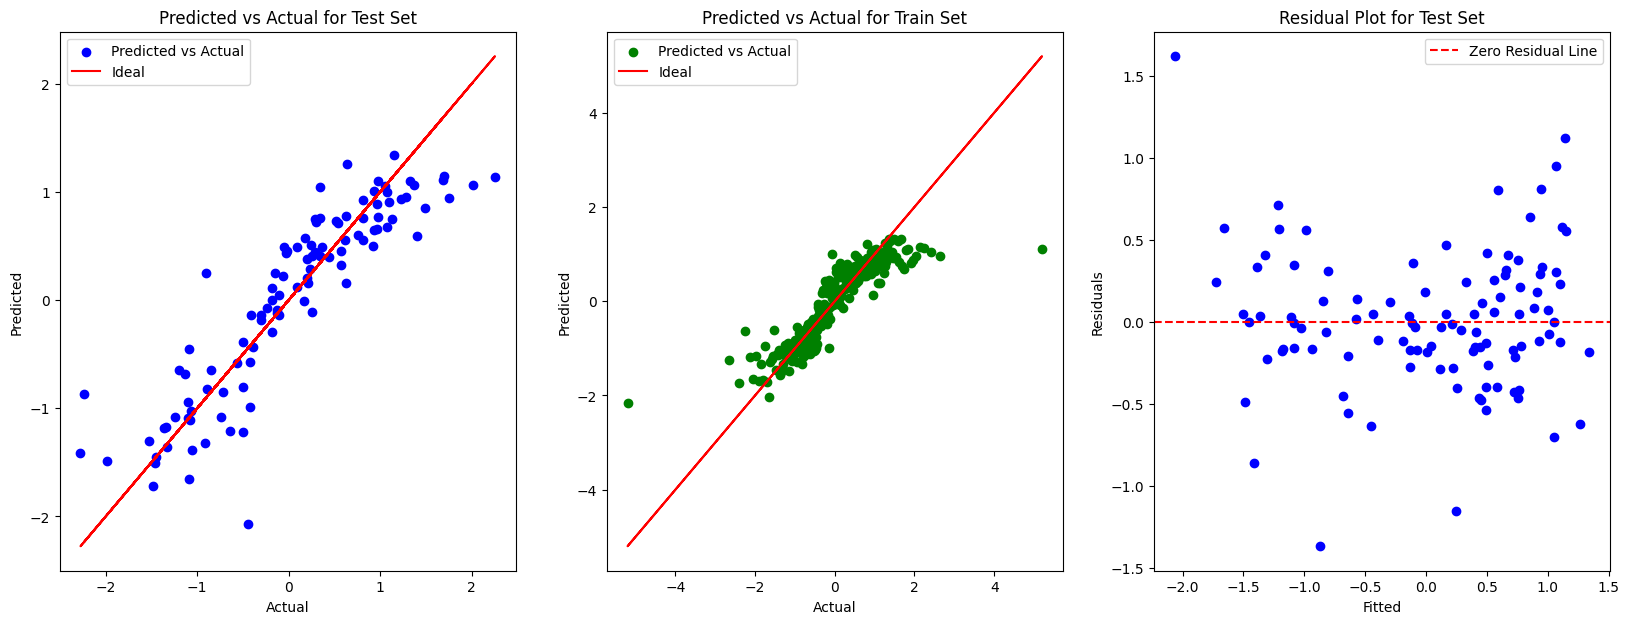

In [131]:
reg = HuberRegressor(alpha=5, epsilon=1.668503, max_iter=1000)
featureImportanceTrans(reg)
test_model_2(reg)

I read somewhere that it's easy to get from 0-80% accuracy is easy, but getting that last 20% can take forever so I'll stop here.
<br>While our RMSE looks high, we have a range of 0-35000 daily demand for bikes so it's actually relatively ok
<br>Now we can take a deeper look at how our model actually behaves

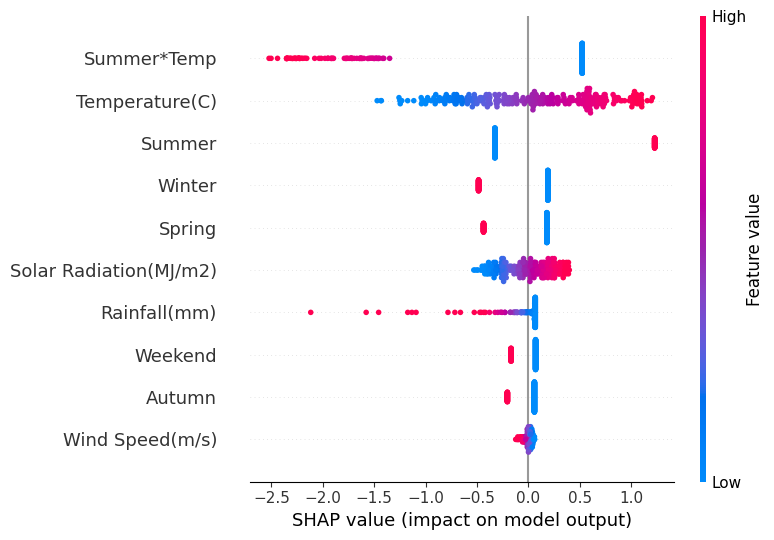

In [106]:
import shap

explainer = shap.LinearExplainer(reg, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

In [107]:
X.describe()

,Temperature(C),Wind Speed(m/s),Solar Radiation(MJ/m2),Rainfall(mm),Spring,Summer,Autumn,Winter,Weekend,Summer*Temp
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,12.774304,1.726558,2.069207,3.635411,0.254958,0.260623,0.229462,0.254958,0.288952,6.928093
std,11.717670,0.597551,0.909086,12.002475,0.436456,0.439598,0.421084,0.436456,0.453919,11.831265
min,-14.737500,0.662500,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.304167,1.304167,1.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.737500,1.658333,2.230000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22.591667,1.954167,2.870000,0.500000,1.000000,1.000000,0.000000,1.000000,1.000000,21.304167
max,33.741667,4.000000,3.520000,95.500000,1.000000,1.000000,1.000000,1.000000,1.000000,33.741667


I'm going to try scaling everything to see if that improves anything

In [108]:
from sklearn.preprocessing import StandardScaler
def transformData(Xtrain, Xtest, ytrain, ytest):
	# Taking out our non-numerical features from the scaler
    scale_columns = ['Temperature(C)', 'Wind Speed(m/s)', 'Solar Radiation(MJ/m2)', 'Rainfall(mm)']
    no_scale = ['Spring', 'Summer', 'Autumn', 'Winter', 'Summer*Temp']

	# Separating numerical data from the rest
    no_scale_train = Xtrain[no_scale]
    no_scale_test = Xtest[no_scale]
    train_to_scale = Xtrain[scale_columns]
    test_to_scale = Xtest[scale_columns]

	# standardizing all features
    scaler = StandardScaler()
    scaled_x_train = scaler.fit_transform(train_to_scale)
    scaled_x_test = scaler.transform(test_to_scale)

    # converting scaled data into dataframes to concat
    scaled_x_train = pd.DataFrame(scaled_x_train, index=Xtrain.index, columns=train_to_scale.columns)
    scaled_x_test = pd.DataFrame(scaled_x_test, index=Xtest.index, columns=test_to_scale.columns)
    
    # concating the non-numerical data with the numerical
    Xtrain = pd.concat([scaled_x_train, no_scale_train], axis=1)
    Xtest = pd.concat([scaled_x_test, no_scale_test], axis=1)
    return Xtrain, Xtest, ytrain, ytest
X_train, X_test, y_train, y_test = transformData(X_train, X_test, y_train, y_test)

In [109]:
featureImportanceTrans(reg)

Test Accuracy: 88.34%
Train Accuracy: 87.54%
Mean Squared Error: 11193531.31
Root Mean Squared Error: 3345.67
                  Feature  Importance
5                  Summer    1.463256
7                  Winter   -0.664784
0          Temperature(C)    0.631066
4                  Spring   -0.567727
3            Rainfall(mm)   -0.267171
2  Solar Radiation(MJ/m2)    0.248219
6                  Autumn   -0.230141
8             Summer*Temp   -0.085384
1         Wind Speed(m/s)   -0.031174


Even after tuning in `modeling.ipynb`, using the scaler just leads in higher rmse so we wont use it